In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import random
from tqdm import tqdm
import dgl
import networkx as nx
from torchvision import transforms
from torchvision.datasets import STL10
from torchvision.io import read_image
#import torchvision.transforms.functional as F

import os
import glob
from PIL import Image

In [2]:
target_size=(256,256)
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.377,0.249),
    transforms.Resize(target_size),
    transforms.Grayscale()
])

In [9]:
image=transform(Image.open('../data/car/front/0_019.jpg'))
print(image.shape)

torch.Size([1, 256, 256])


/home/mi22a004/anaconda3/envs/DGL/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [6]:
image=np.array(image).transpose(1,2,0)

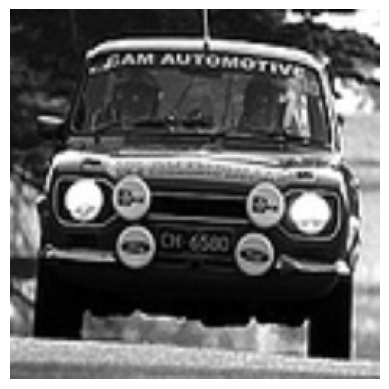

In [8]:
plt.imshow(image,cmap='gray')
plt.axis('off')
plt.show()

In [10]:
def get_nearest_neighbors(image, row, col): #最近傍ノード番号の取得
    # 画像の形状を取得
    height, width = image.shape[:2]

    # 注目画素の周囲8画素の座標を計算
    neighbors_coords = [(row-1, col-1), (row-1, col), (row-1, col+1),
                        (row, col-1), (row, col+1),
                        (row+1, col-1), (row+1, col), (row+1, col+1)]

    # 注目画素の最近傍画素の値を抜き出す
    nearest_neighbors = []
    for r, c in neighbors_coords:
        # 座標が画像範囲内かチェック
        if 0 <= r < height and 0 <= c < width:
            pixel_value = image[r, c]
            nearest_neighbors.append(pixel_value)
        else:
            # 画像範囲外の場合は0を追加するなど適切な処理を行う
            #nearest_neighbors.append(0)
            pass

    return nearest_neighbors


def get_15nearest_neighbors(image, row, col):
    # 画像の形状を取得
    height, width = image.shape[:2]

    neighbors_coords=[(row-2,col-2),(row-2,col-1),(row-2,col),(row-2,col+1),(row-2,col+2),
                      (row-1,col-2),(row-1,col-1),(row-1,col),(row-1,col+1),(row-1,col+2),
                      (row,col-2),  (row, col-1),             (row, col+1), (row,col+2),
                      (row+1,col-2),(row+1,col-1),(row+1,col),(row+1,col+1),(row+1,col-2),
                      (row+2,col-2),(row+2,col-1),(row+2,col),(row+2,col-1),(row+2,col-2)]
    # 注目画素の最近傍画素の値を抜き出す
    nearest_neighbors = []
    for r, c in neighbors_coords:
        # 座標が画像範囲内かチェック
        if 0 <= r < height and 0 <= c < width:
            pixel_value = image[r, c]
            nearest_neighbors.append(pixel_value)
        else:
            # 画像範囲外の場合は0を追加するなど適切な処理を行う
            pass

    return nearest_neighbors


def make_graph(side_length): #パッチ数分のグラフを作成
    g=dgl.DGLGraph()
    g.add_nodes(side_length**2)
    square_list = np.arange(side_length**2).reshape((side_length, side_length))
    #ノード番号に対応したインデックスを取得
    inds=np.ndindex(square_list.shape)
    inds=[idx for idx in inds]
    #各ノードと最近傍ノード間にエッジを張る
    for i in range(side_length**2):
        x,y=inds[i]
        flatt_nh=get_nearest_neighbors(square_list,x,y)
        for j in flatt_nh:
            if i == j:
                continue
            else:
                g.add_edges(j,i)
    return g


def image_patch(image,num_patch):
    #画像サイズ
    size=image.shape[1]
    #1パッチ当たりの画素数
    patch_width=int(size/num_patch)
    #パッチ保存用配列
    data=[]

    for i in range(0,size,patch_width):
        for j in range(0,size,patch_width):
            data.append(image[:, i : i + patch_width, j : j + patch_width])
    
    return torch.stack(data,dim=0)


def get_rot90_index(arr):
    row,col=arr.shape
    indices=np.ndindex(arr.shape)#インデックス計算
    all_indices=[idx for idx in indices]#リストに変換
    rot90=np.array(all_indices).reshape((row,col,2))#3,3,2に変形
    rot90=np.rot90(rot90,k=1)#90度回転
    rot90_flatt=rot90.reshape(row*col,2)#フラットに変換
    return rot90_flatt


In [11]:
#パッチ数
num_patch=8
#画像をパッチに分割
n_feat=image_patch(image,num_patch)
#グラフ作成
G=make_graph(num_patch)
#グラフにノード特徴 'f' としてパッチ画像を入力
G.ndata['f']=n_feat

/home/mi22a004/anaconda3/envs/DGL/lib/python3.10/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


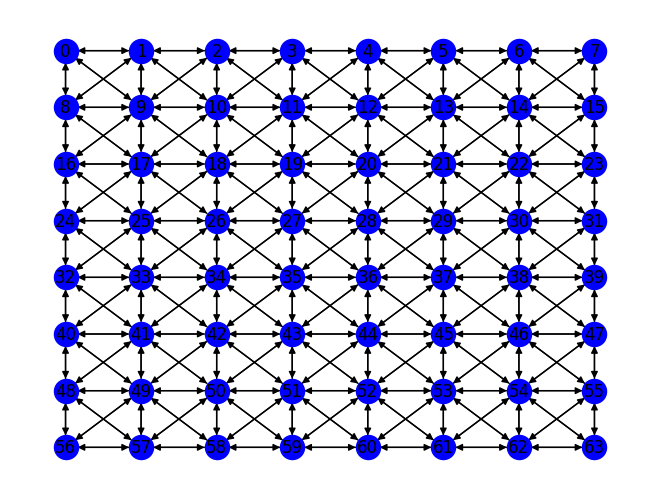

In [12]:
rand_array=np.zeros((num_patch,num_patch))
rot90=get_rot90_index(rand_array)

pos={}
for i in range(num_patch**2):
    pos[i]=rot90[i]
square_list = np.arange(num_patch**2).reshape((num_patch, num_patch))
inds=np.ndindex(square_list.shape)
inds=[idx for idx in inds]
g=G.to_networkx()
nx.draw(g,pos,with_labels=True,node_color='blue')
plt.show()

100%|██████████| 64/64 [00:00<00:00, 524.07it/s]


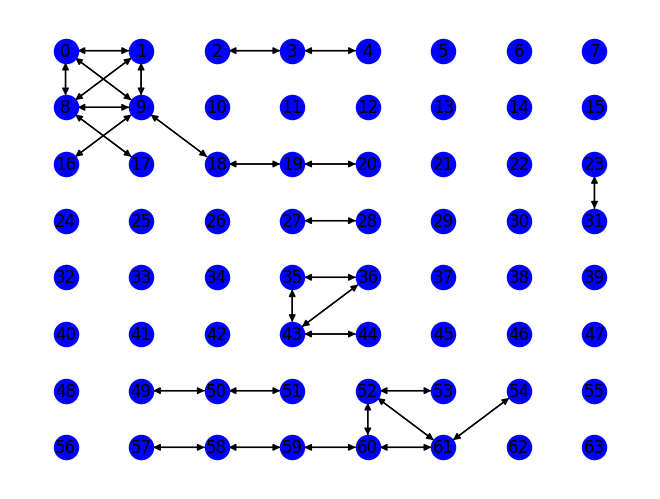

In [13]:
eids=[]
cos=nn.CosineSimilarity(1)
thresh=0.8
for n in tqdm(range(num_patch**2)):
    #ノード番号nのノード特徴を取り出しフラット化
    p0=torch.flatten(G.ndata['f'][n].unsqueeze(0),1)
    #ノード番号nの隣接ノードのノード特徴を取り出しフラット化
    p1=torch.flatten(G.ndata['f'][G.successors(n)],1)
    #コサイン類似度を計算し、閾値以下のインデックスをTrueとする真偽値リストを取得
    boolval=torch.abs(cos(p0,p1)) < thresh
    #閾値以下のエッジを切るためのエッジidの取得
    for i,j in enumerate(G.successors(n)):
        if boolval[i]:
            eids.append(G.edge_ids(n,j).item())
    
#切るべきエッジidを用いてグラフGからエッジを削除
cutG=dgl.remove_edges(G,eids)
#結果を描画
nx_cutg=cutG.to_networkx()
nx.draw(nx_cutg,pos,with_labels=True,node_color='blue')
plt.show()

256
32


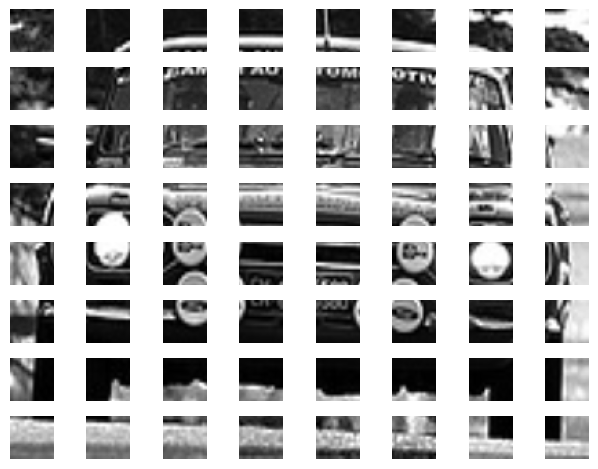

patch num: 8  patch pic size: 32


In [14]:
nimage=np.array(torch.permute(image,(1,2,0)))
size=nimage.shape[0]
print(size)
patch_width=int(size/num_patch)
print(patch_width)
data=[]

for i in range(0,size,patch_width):
    #print(i)
    for j in range(0,size,patch_width):
        #print(j)
        data.append(nimage[i: i + patch_width,j: j + patch_width, :])

#分割した各パッチを正方形に表示
# 1枚の図を作成
fig = plt.figure()

# 画像を追加
for i in range(num_patch**2):
    ax = fig.add_subplot(num_patch, num_patch, i+1)
    ax.imshow(data[i],cmap='gray')
    ax.axis('off')

# 画像を表示
plt.tight_layout()
plt.show()
print(f'patch num: {num_patch}  patch pic size: {patch_width}')

In [105]:
names=glob.glob('../data/car/front/*')
print((names))
m=0
std=0
for name in names:
    img=transform(Image.open(name))
    m+=img.mean()
    std+=img.std()

['../data/car/front/0_043.jpg', '../data/car/front/0_007.jpg', '../data/car/front/0_008.jpg', '../data/car/front/0_038.jpg', '../data/car/front/0_045.jpg', '../data/car/front/0_003.jpg', '../data/car/front/0_036.jpg', '../data/car/front/0_027.jpg', '../data/car/front/0_026.jpg', '../data/car/front/0_041.jpg', '../data/car/front/0_005.jpg', '../data/car/front/0_025.jpg', '../data/car/front/0_028.jpg', '../data/car/front/0_004.jpg', '../data/car/front/0_039.jpg', '../data/car/front/0_031.jpg', '../data/car/front/0_021.jpg', '../data/car/front/0_001.jpg', '../data/car/front/0_009.jpg', '../data/car/front/0_014.jpg', '../data/car/front/0_042.jpg', '../data/car/front/0_037.jpg', '../data/car/front/0_040.jpg', '../data/car/front/0_013.jpg', '../data/car/front/0_015.jpg', '../data/car/front/0_022.jpg', '../data/car/front/0_006.jpg', '../data/car/front/0_035.jpg', '../data/car/front/0_018.jpg', '../data/car/front/0_020.jpg', '../data/car/front/0_044.jpg', '../data/car/front/0_029.jpg', '../dat

In [107]:
print(f'mean:{m/len(names)} std:{std/len(names)}')

mean:0.37759149074554443 std:0.24980495870113373


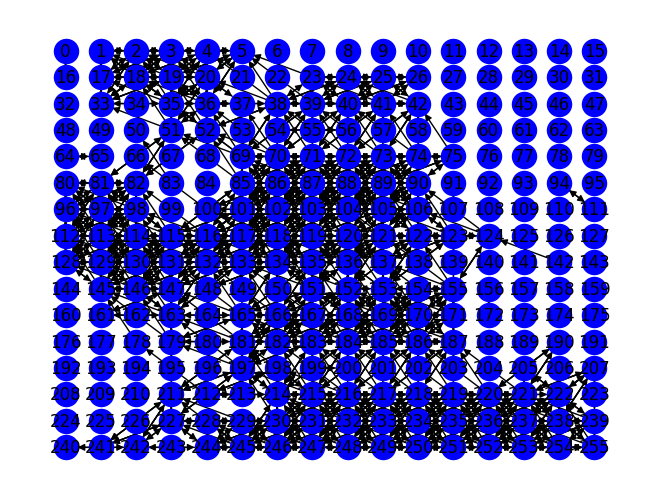

In [32]:
#15近傍ノードの類似度によるグラフ作成
target_size=(256,256)
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.377,0.249),
    transforms.Resize(target_size),
    transforms.Grayscale()
])

#類似度閾値
thresh=0.8
cos=nn.CosineSimilarity(1)
image=transform(Image.open('../data/car/front/0_001.jpg'))
#パッチ数
num_patch=16
#画像をパッチに分割
n_feat=image_patch(image,num_patch)

#グラフ作成
g=dgl.DGLGraph()
g.add_nodes(num_patch**2)
square_list = np.arange(num_patch**2).reshape((num_patch, num_patch))
#ノード番号に対応したインデックスを取得
inds=np.ndindex(square_list.shape)
inds=[idx for idx in inds]

for n in range(num_patch**2):
    x,y=inds[n]
    neighbor_nodes=get_15nearest_neighbors(square_list,x,y)
    
    p0=torch.flatten(n_feat[n].unsqueeze(0),1)
    p1=torch.flatten(n_feat[neighbor_nodes],1)
    boolval=torch.abs(cos(p0,p1)) > thresh
    add_edges=[]
    for i,tf in enumerate(boolval):
        if tf:
            g.add_edges(n,neighbor_nodes[i])

nx.draw(g.to_networkx(),pos,with_labels=True,node_color='blue')
plt.show()

In [23]:
a=2
b=19
print(cos(torch.flatten(n_feat[a].unsqueeze(0),1),torch.flatten(n_feat[b].unsqueeze(0),1)))

tensor([-0.9160])
